<a href="https://colab.research.google.com/github/danielpappa/NewsBot/blob/main/NewsBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NewsBot**

This code was inspired by the work done in HuggingFace's [Open-Source AI Cookbook](https://github.com/huggingface/cookbook) by 20+ contributors as visible in the repository. Their approach of RAG-evaluation by creating an LLM-as-a-judge was particularly helpful.


### Set-Up

In [ ]:
!pip -q install datasets
!pip -q install sentence_transformers
!pip -q install faiss-cpu
!pip -q install faiss-gpu
!pip -q install langchain
!pip -q install langchain_community
!pip -q install evaluate
!pip -q install rouge_score
!pip -q install bert_score
!pip -q install px

In [ ]:
import pandas as pd
import numpy as np
import datasets
import seaborn as sns
import faiss
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import json
import glob
import plotly.express as px
import pathlib
import re


from datasets import Dataset
from sentence_transformers import SentenceTransformer, util
from enum import Enum
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from ast import literal_eval
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
from typing import List, Tuple
from evaluate import load
from transformers import AutoTokenizer

from langchain.docstore.document import Document as LangchainDocument
from langchain.vectorstores import FAISS
from langchain_community.llms import HuggingFaceHub
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer
from langchain_community.vectorstores.utils import DistanceStrategy

In [ ]:
from google.colab import userdata
import os

hf_token = userdata.get('HF_TOKEN')
os.environ["HUGGINGFACEHUB_API_TOKEN"] = hf_token

### **Getting the Data**

The data used in the following section comprises news articles from the 4th of April, 2024 until the 4th of May, 2024 from both The Guardian and The New York Times. The respective articles where accessed through the freely available APIs on the journal's developer portals and processed into a final dataset which is available online on [HuggingFace](https://huggingface.co/datasets/danielpappa/News).

In [ ]:
ds = datasets.load_dataset("danielpappa/News", split="train")

news_df = ds.to_pandas()
news_df['Summary'] = news_df['Summary'].str.split('More about').str[0] # to remove unnecessary information about the content's author
news_df = news_df.drop(news_df[news_df['Summary'].str.len() < 50].index) # removing articles with less than 50 characters
news_df = news_df.drop(news_df[news_df['Summary'].values == None].index) # removing NaNs
news_df = news_df.drop(columns=['Unnamed: 0'])
ds = Dataset.from_pandas(news_df)

#### Data Analytics

In [ ]:
news_df.head()

,Title,Summary,Contributors,Date,Section,Url,Source
0,Tesla Pullback Puts Onus on Others to Build El...,"Elon Musk, the chief executive of Tesla, blind...",By Jack Ewing and Ivan Penn,2024-05-04 05:04:41-04:00,business,https://www.nytimes.com/2024/05/04/business/en...,The New York Times
1,Billionaire Donor Assails Brown’s ‘Unconsciona...,"One of Brown University’s major donors, the bi...",By Rob Copeland,2024-05-03 19:21:00-04:00,business,https://www.nytimes.com/2024/05/03/business/st...,The New York Times
2,Berkshire Reports Drop in Profits but Formidab...,Berkshire Hathaway on Saturday reported a shar...,By Michael J. de la Merced,2024-05-04 09:38:58-04:00,business,https://www.nytimes.com/2024/05/04/business/de...,The New York Times
3,"Oil Companies Expand Offshore Drilling, Pointi...","About 80 miles southeast of Louisiana’s coast,...",By Ivan Penn,2024-05-03 05:00:46-04:00,business,https://www.nytimes.com/2024/05/03/business/en...,The New York Times
4,The Perils of the Fed’s Vast Bond Holdings,The Federal Reserve is engaged in a colossal t...,By Jeff Sommer,2024-05-03 09:00:15-04:00,business,https://www.nytimes.com/2024/05/03/business/fe...,The New York Times


<Axes: ylabel='Section'>

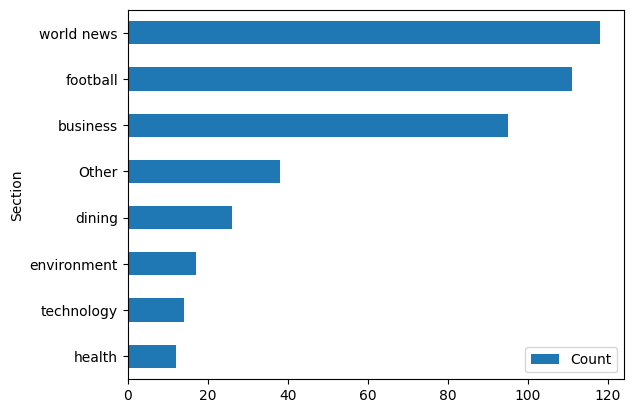

In [ ]:
sections = pd.DataFrame({'Section': news_df.Section.str.lower().value_counts().keys(), 'Count': news_df.Section.str.lower().value_counts().values})
other_count = sections[sections.Count < 10].Count.sum()
world_count = sections[sections.Section == 'world'].Count.sum()
main_sections = sections[sections.Count >= 10]
main_sections = main_sections[main_sections.Section != 'world']
main_sections.loc[main_sections.Section == 'world news', 'Count'] += world_count
main_sections.loc[-1] = ['Other', other_count]
main_sections.sort_values(by=['Count']).plot(x='Section', y='Count', kind='barh')

In [ ]:
import matplotlib.dates as mdates
rounded_times = [d.round(freq='h') for d in pd.to_datetime(news_df['Date']).values]
time_series = pd.DataFrame(rounded_times).value_counts().reset_index()
time_series.columns = ['Date', 'Count']

<Axes: xlabel='Date'>

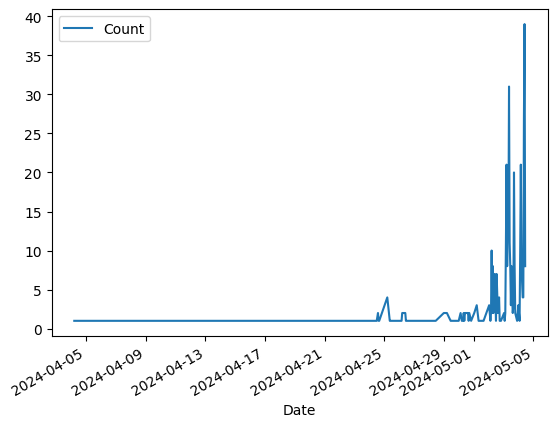

In [ ]:
time_series.plot(x='Date', y='Count')

#### LLM Set-Up

In [ ]:
class Model(Enum):
  MISTRAL = "mistralai/Mistral-7B-Instruct-v0.2"
  MISTRAL8X7B = "mistralai/Mixtral-8x7B-Instruct-v0.1"
  META = "meta-llama/Meta-Llama-3-8B-Instruct"

class Embeddings(Enum):
  GTE_SMALL = "thenlper/gte-small"
  GTE_BASE = "thenlper/gte-base"
  GTE_LARGE = "thenlper/gte-large"

provider: Model = Model.MISTRAL
embedder: Embeddings = Embeddings.GTE_SMALL

#### Sentence Similarity

In [ ]:
titles = ["Summary of the day", "Closing summary", "Closing post", "FTSE 100 at new record high", "Play-off details"]
search_text = ["Summarize the daily news"]
model = Embeddings.GTE_LARGE.value #thenlper/gte-large (dimension = 1024)

#Compute embedding for both lists
encoder = SentenceTransformer(model)
embeddings = encoder.encode(titles + search_text)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

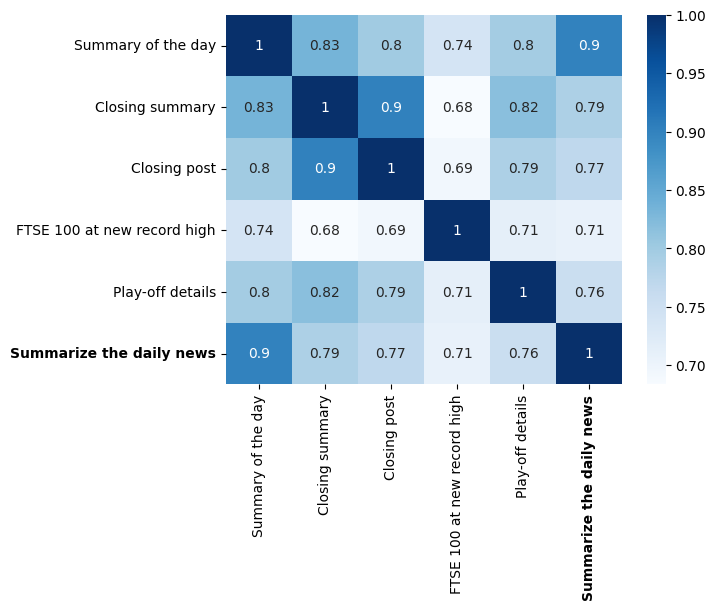

In [ ]:
cs = cosine_similarity(embeddings, embeddings)

titles_heatmap = sns.heatmap(cs, xticklabels=titles+search_text, yticklabels=titles+search_text, cmap="Blues", annot=True)
for label in titles_heatmap.get_yticklabels():
    if label.get_text() == "Summarize the daily news":
        label.set_weight("bold")
for label in titles_heatmap.get_xticklabels():
    if label.get_text() == "Summarize the daily news":
        label.set_weight("bold")

In [ ]:
embedding_dimension = embeddings.shape[1]
faiss.normalize_L2(embeddings)
index = faiss.IndexFlatL2(embedding_dimension)
index.add(embeddings)

search_vector = np.array([encoder.encode(search_text[0])])
faiss.normalize_L2(search_vector)

np.set_printoptions(threshold=15)
print(search_vector)

[[ 0.01136288 -0.01046212 -0.00802551 ... -0.0210812  -0.02210982
   0.00438737]]


<Axes: >

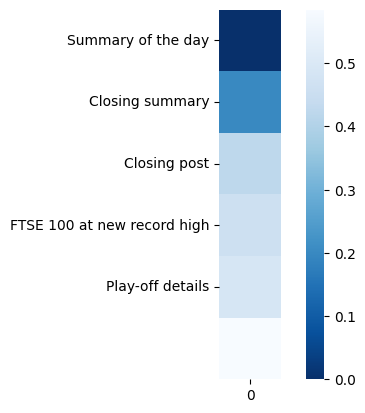

In [ ]:
distances, ann = index.search(search_vector, k=index.ntotal)
results = pd.DataFrame({'distances': np.around(np.clip(distances[0], 0, 1), decimals=4), 'ann': ann[0]})

distance_heatmap = sns.heatmap(np.transpose(distances), yticklabels=titles, cmap="Blues_r", square=True)
distance_heatmap

#### t-Distributed Stochastic Neighbour Embedding (t-SNE)

In [ ]:
df = pd.DataFrame(embeddings) # 1024 dimensional embeddings
df['Embeddings'] = str(df.values.tolist())
matrix = np.array(df.Embeddings.apply(literal_eval).to_list())
tsne = TSNE(n_components=2, perplexity=4, random_state=5, init='random', learning_rate=600) # dimensionality reduction
vis_dims = tsne.fit_transform(matrix[0])
vis_dims.shape

(6, 2)

In [ ]:
reduced_embeddings = pd.DataFrame(vis_dims)
reduced_embeddings["Labels"] = titles + search_text

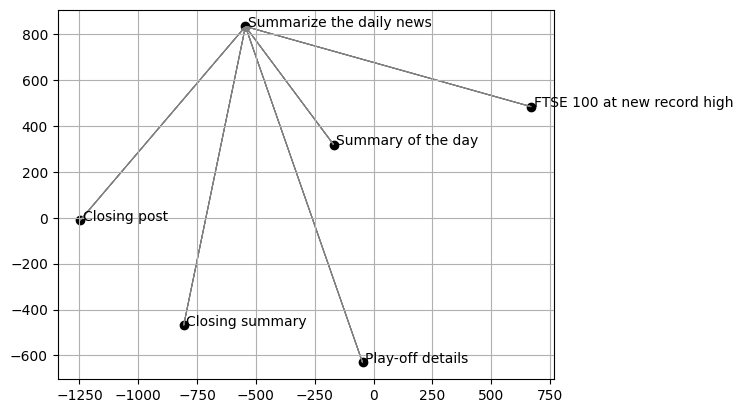

In [ ]:
plt.scatter(reduced_embeddings[0], reduced_embeddings[1], color="black")
plt.grid(True)
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+10, point['y'], str(point['val']))
        ax.quiver(x, y, (reduced_embeddings[0][5]-x), (reduced_embeddings[1][5]-y), angles='xy', scale_units='xy', scale=1, color="grey", width=0.002)

label_point(reduced_embeddings[0], reduced_embeddings[1], reduced_embeddings['Labels'], plt.gca())

#### CBOW

In [ ]:
sentences = [
					"The oil price has risen",
					"The US dollar has tumbled",
					"US wage growth slows",
					"US jobless claims flat"
					     ]

# Convert the sentences to a sequence of integers bearing repetitions in mind
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
print(sequences)

[[2, 4, 5, 3, 6], [2, 1, 7, 3, 8], [1, 9, 10, 11], [1, 12, 13, 14]]


In [ ]:
vocab_size = len(tokenizer.word_index) + 1
embedding_size = 10
window_size = 2

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
					output_dim=embedding_size,
					input_length=2*window_size))
model.add(Lambda(lambda x: tf.reduce_mean(x, axis=1)))
model.add(Dense(units=vocab_size, activation='softmax'))
model.save_weights('cbow_weights.h5')
model.load_weights('cbow_weights.h5')

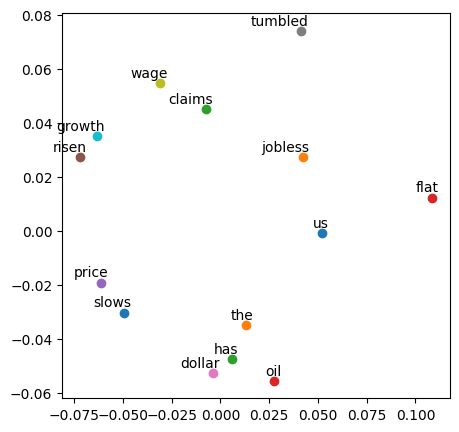

In [ ]:
cbow_embeddings = model.get_weights()[0]

pca = PCA(n_components=2) # principal component analysis to reduce embedding dimensionality to 2
reduced_embeddings = pca.fit_transform(cbow_embeddings)

fig = plt.figure(figsize=(5, 5))

for i, word in enumerate(tokenizer.word_index.keys()):
	x, y = reduced_embeddings[i]
	plt.scatter(x, y)
	plt.annotate(word, xy=(x, y), xytext=(5, 2),
				textcoords='offset points',
				ha='right', va='bottom')
plt.show()

### **Creating the RAG Model**

#### Embeddings and Vector Store using Langchain and FAISS

In [ ]:
#Storing references as metadata of a Langchain document

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["Summary"], metadata={"title": doc["Title"], "authors": doc["Contributors"], "url": doc["Url"], "source": doc["Source"]})
    for doc in tqdm(ds)
]

  0%|          | 0/440 [00:00<?, ?it/s]

In [ ]:
RAW_KNOWLEDGE_BASE[0]

Document(page_content='Elon Musk, the chief executive of Tesla, blindsided competitors, suppliers and his own employees this week by reversing course on his aggressive push to build electric vehicle chargers in the United States, a major priority of the Biden administration.Mr. Musk’s decision to lay off the 500-member team responsible for installing charging stations, and to sharply slow investment in new stations, baffled the industry and raised doubts about whether the number of public chargers would grow fast enough to keep pace with sales of battery-powered cars. It put the onus on other charging companies, raising questions about whether they can build fast enough to address a shortage that appears to be discouraging some people from buying electric cars.As the owner of the largest charging network in the United States, Tesla has a powerful effect on people’s views of electric cars.“There is certainly a psychological component,” said Robert Zabors, a senior partner at Roland Berg

In [ ]:
# Function to split the documents into chunks using Langchain

def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: str,
) -> List[LangchainDocument]:

    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=["\n\n", "\n", ".", " ", ""],
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique

In [ ]:
# Function to generate normalized embeddings from a list of Langchain documents using @embedding_model_name
# and returning a FAISS vector store index for efficient vector search and retrieval

def load_embeddings(
    langchain_docs: List[LangchainDocument],
    chunk_size: int,
    embedding_model_name: Embeddings,
    folder_path: str,
    test_on_marco=False,
) -> FAISS:

    embedding_model = HuggingFaceEmbeddings(
        model_name=embedding_model_name,
        multi_process=True,
        show_progress=True,
        model_kwargs={"device": "cuda"}, #cuda, cpu
        encode_kwargs={"normalize_embeddings": True},  # cosine similarity
    )

    if test_on_marco:
      index_folder_path = folder_path
    else:
      index_name = f"index_chunk:{chunk_size}_embeddings:{embedding_model_name.replace('/', '~')}"
      index_folder_path = f"{folder_path}/{index_name}/"

    if os.path.isdir(index_folder_path):
      print("Embeddings already generated, here you go:")
      return FAISS.load_local(
          index_folder_path,
          embedding_model,
          distance_strategy=DistanceStrategy.COSINE,
          allow_dangerous_deserialization=True,
      )

    else:
      print("File with embeddings not found, generating it...")
      docs_processed = split_documents(
          chunk_size,
          langchain_docs,
          embedding_model_name,
      )
      knowledge_index = FAISS.from_documents(
          docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
      )
      knowledge_index.save_local(index_folder_path)
      return knowledge_index

#### Vector Search and Text Generation


In [ ]:
llm = provider.value # 'mistralai/Mistral-7B-Instruct-v0.2'

def define_base_model(temperature) -> HuggingFaceHub:
  base_model = HuggingFaceHub(
      repo_id=llm,
      task="text-generation",
      model_kwargs={
          "max_new_tokens": 512, # max output length - to save tokens and power (>= chunk_size)
          "top_k": 30, # number of highest probability words to consider at each step
          "temperature": temperature, # ranges from 0 to 1
          "repetition_penalty": 1.05, # to incentive the model to not repeat same words/sentences
      },
  )
  return base_model
BASE_MODEL = define_base_model(0.2) # low temperature to decrease randomness in the model's answers (0-1)

In [ ]:
# Prompt engineering appoach to instruct the base_model
mistral_tokenizer = AutoTokenizer.from_pretrained(provider.value)

chat = [
  {"role": "user", "content": "Using only the information contained in the context, give a short and comprehensive answer to the question. Do not access any provided links to formulate your answer. Respond only to the question asked, your response should be concise and relevant to the question. Please make sure to always provide all the sources you used in apa style as a bullet list in a paragraph titled 'References' at the end of your response. If the answer cannot be deduced from the context, do not give an answer. This is the context: {context} -- Now here is the question you need to answer: {question}"},
]
RAG_PROMPT_TEMPLATE = mistral_tokenizer.apply_chat_template(chat, tokenize=False) # to use the appropriate formatting for mistral instruct models (adds [INST] ... [/INST])

In [ ]:
# Function to call the RAG pipeline

def answer_with_rag(
    question: str,
    llm: HuggingFaceHub,
    knowledge_index: FAISS,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 7,
) -> Tuple[str, List[LangchainDocument]]:

    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)

    relevant_docs = relevant_docs[:num_docs_final] # gets the most relevant documents retrieved

    context = "\nExtracted documents:\n"
    context += "".join([f"Title: {str(doc.metadata['title'])}\nAuthors: {str(doc.metadata['authors'])}\nSource: {str(doc.metadata['source'])}\nURL: {str(doc.metadata['url'])}:::\n" + doc.page_content for doc in relevant_docs])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    answer = llm.invoke(final_prompt)

    return answer, relevant_docs

#### Example Usage

This section showcases an example set-up and use of the RAG model. In the end, users will be able to ask news-related questions and should obtain truthful answers based on the context from the closest matching articles in the dataset. References should also be provided by the output.

In [ ]:
# define a vector store to perform search on

KNOWLEDGE_INDEX = load_embeddings(RAW_KNOWLEDGE_BASE, chunk_size=256, embedding_model_name=Embeddings.GTE_LARGE.value, folder_path="drive/MyDrive/data/embeddings") # thenlper/gte-small

In [ ]:
def news_bot(query):
  a, r = answer_with_rag(query, BASE_MODEL, KNOWLEDGE_INDEX)
  a = a.split('[/INST]')[-1].split('</s>')[0]
  return a, r

In [ ]:
queries = ["Summarize the daily news", "How is the NBA title race going?", "How did AC Milan play this past weekend?"]#["What are the latest news in football?", "Tell me more about the presidential elections in the US."]
answers, sources = [news_bot(query)[0] for query in queries], [news_bot(query)[1] for query in queries]

In [ ]:
data = {'Queries': queries, 'Answers': answers, 'Sources': sources}
example_df = pd.DataFrame(data)
example_df

,Queries,Answers,Sources
0,Summarize the daily news,The Guardian published live coverage of the M...,[page_content='Here are some of the latest ima...
1,How is the NBA title race going?,"Based on the context provided, the NBA title ...",[page_content='The Premier League Title Race t...
2,How did AC Milan play this past weekend?,"Based on the provided context, AC Milan's gam...",[page_content='90+6 mins: Nothing flash now fr...


In [ ]:
print(answers[0])

 The Guardian published live coverage of the Middle East crisis, including hostage situations in Israel and ceasefire talks with Hamas. The New York Times reported on Warren Buffett's upcoming discussion on the economy, elections, and investment opportunities. The Times also highlighted the significant role of student journalists in covering campus protests related to the situation in Gaza. Other news included Peloton's CEO stepping down and the company cutting 15% of its staff, Iran releasing the crew of an Israel-linked ship it had detained, and Rishi Sunak facing scrutiny as the UK Conservative Party leader amidst a string of bad news (Mark Landler).

References:
- Leily Nikounazar and Christopher F. Schuetze. (2024, May 03). Iran Says It Released Crew of Israel-Linked Ship It Detained. The New York Times. <https://www.nytimes.com/2024/05/03/world/middleeast/iran-israel-ship-crew.html>
- Michael J. de la Merced. (2024, May 04). Buffett to Discuss Economy, Elections and Investment Op

### **Evaluation**

This section will attempt to evaluate the above model based on some common metrics to grade LLMs.

#### Metrics for Retrieval

The retriever will be evaluated on a selected subset of the test set of the commonly used MS Marco dataset (in order to exploit its ground truth). Since the test is structured to test the retriever's ability on multiple small datasets, the best performing value for the number of retrieved documents is not truly informative about the news dataset used for this project, but gives nonetheless some insights into metrics for retriever evaluation.

In [ ]:
ms_marco = datasets.load_dataset("microsoft/ms_marco", "v1.1", split="test")
ms = ms_marco.to_pandas()
marco_questions = np.unique(ms['query'].values)

In [ ]:
def create_kb(queries):
  df = pd.DataFrame(columns=['Query', 'Passages', 'Selected'])
  for query in queries:
    passages = ms[ms['query'] == query].passages
    is_selected = list(passages.values[0]['is_selected'])
    passage_text = list(passages.values[0]['passage_text'])
    df = pd.concat([df, pd.DataFrame({'Query': query, 'Passages': passage_text, 'Selected': is_selected})])
  return Dataset.from_pandas(df)

In [ ]:
def create_vector_indexes(questions, n):

  questions = questions[:n]

  for question in tqdm(questions):
    data = create_kb([question])
    KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["Passages"], metadata={"Query": doc["Query"], "Selected": doc["Selected"]})
    for doc in data
    ]
    KNOWLEDGE_INDEX = load_embeddings(KNOWLEDGE_BASE, chunk_size=256, embedding_model_name=embedder.value, folder_path=f"drive/MyDrive/evaluation_256_small/embeddings/{question}", test_on_marco=True)

In [ ]:
#create_vector_indexes(marco_questions, 1000) reached 300 with 8:36 hours to go...

In [ ]:
def precision_recall_f1(questions, n, ks):

  questions = questions[:n]

  if not os.path.exists("drive/MyDrive/measures_256"):
      os.mkdir("drive/MyDrive/measures_256")

  file_name = f"drive/MyDrive/measures_256/retrieval.json"

  for k in tqdm(ks):

    precisions = []
    recalls = []
    f1_scores = []

    for question in tqdm(questions):
      data = create_kb([question])
      KNOWLEDGE_BASE = [
      LangchainDocument(page_content=doc["Passages"], metadata={"Query": doc["Query"], "Selected": doc["Selected"]})
      for doc in data
      ]
      KNOWLEDGE_INDEX = load_embeddings(KNOWLEDGE_BASE, chunk_size=256, embedding_model_name=embedder.value, folder_path=f"drive/MyDrive/evaluation_256_small/embeddings/{question}", test_on_marco=True)

      relevant_docs = KNOWLEDGE_INDEX.similarity_search_with_relevance_scores(query=question, k=10)
      retrieved_docs = relevant_docs[:min(k, len(relevant_docs))] # gets the most relevant documents retrieved

      number_correctly_retrieved = sum([retrieved_docs[i][0].metadata['Selected'] for i in range(len(retrieved_docs))])
      number_actually_correct = sum([relevant_docs[i][0].metadata['Selected'] for i in range(len(relevant_docs))])

      precision = number_correctly_retrieved / k
      recall = number_correctly_retrieved / number_actually_correct if number_actually_correct > 0 else 0
      f1_score = 2*(precision*recall)/(precision+recall) if (precision + recall) > 0 else 0

      precisions.append(precision)
      recalls.append(recall)
      f1_scores.append(f1_score)

    p, r, f1 = (sum(precisions)/len(precisions), sum(recalls)/len(recalls), sum(f1_scores)/len(f1_scores))

    retrieval_metrics = {"Question": question, "Values": {f"Precision@{k}": p, f"Recall@{k}": r, "F1_Score": f1, "Number of questions used": n}}

    with open(file_name, "a") as f:
      json.dump(retrieval_metrics, f)

In [ ]:
ks = list(range(1, 11))
precision_recall_f1(marco_questions, 100, ks) # took > 9 hours to load

In [ ]:
with open("drive/MyDrive/measures_256/retrieval.json", "r") as f:
  file = f.read()
file = file.replace('}}{', '}}|{').split('|')
file = [json.loads(file[i])['Values'] for i in range(len(file))]
for i in range(1, 11):
  file[i-1]['@K'] = i
  file[i-1]['Precision'] = file[i-1][f'Precision@{i}']
  file[i-1]['Recall'] = file[i-1][f'Recall@{i}']
  del file[i-1][f'Precision@{i}']
  del file[i-1][f'Recall@{i}']
  del file[i-1]['Number of questions used']
retrieval_metrics = pd.DataFrame(file)[['@K', 'Precision', 'Recall', 'F1_Score']]
retrieval_metrics

,@K,Precision,Recall,F1_Score
0,1,0.410000,0.3775,0.387333
1,2,0.310000,0.5600,0.391667
2,3,0.246667,0.6675,0.353571
3,4,0.217500,0.7975,0.336833
4,5,0.192000,0.8700,0.309841
5,6,0.168333,0.9100,0.280143
6,7,0.148571,0.9400,0.253384
7,8,0.131250,0.9500,0.228000
8,9,0.118889,0.9700,0.209608
9,10,0.107000,0.9700,0.190866


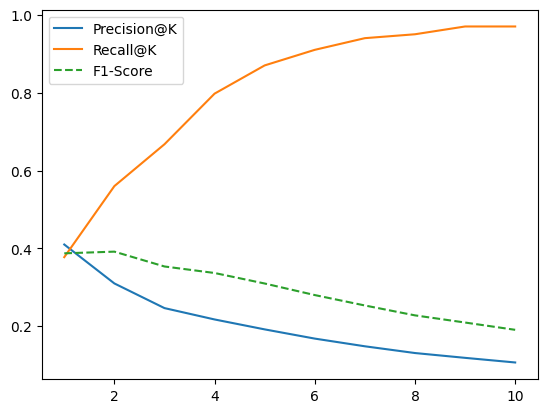

In [ ]:
plt.plot(retrieval_metrics['@K'], retrieval_metrics['Precision'], label='Precision@K')
plt.plot(retrieval_metrics['@K'], retrieval_metrics['Recall'], label='Recall@K')
plt.plot(retrieval_metrics['@K'], retrieval_metrics['F1_Score'], label='F1-Score', linestyle='--')
plt.legend()
plt.show()

#### Metrics for Text Generation

The text generator will be evaluated on a set of 10 questions specifically related to the news domain, comparing the model's response to ground truth answers given the retrieved documents generated partly with ChatGPT-4. ROUGE and BERTscore results will be computed in the next section to optimize computations.

In [ ]:
# 10 potential queries which will be used to analyze the model's capabilities in the following sections

eval_queries = [
    "Summarize latest world news",
    "What happened in the Premier League this weekend?",
    "Is it a good idea to invest in Tesla now?",
    "Give me an overview of the business section of the New York Times",
    "Which countries will hold elections soon?",
    "Did Liverpool win their most recent game?",
    "How is the NBA title race going?",
    "When will Apple launch its next products?",
    "What are the latest news and advancements in AI?",
    "Have there been any recent news about Paramount being acquired by another company??"
]

In [ ]:
def eval(queries, base_model, vector_index, k_retrieved, top_matches):

  responses = [answer_with_rag(query, base_model, vector_index, k_retrieved, top_matches) for query in tqdm(queries)]
  predictions = [prediction[0].split('[/INST]')[-1].split('</s>')[0] for prediction in responses]
  refs = [reference[1] for reference in responses]
  references = ['Article: '.join([i.page_content + str(i.metadata) for i in ref]) for ref in refs]

  return predictions, references

In [ ]:
def init_metrics(chunk_sizes, embedders, k_retrieved, top_matches):

  rag_df = pd.DataFrame(columns=['Question', 'References', 'ChatGPT-4', 'GTE-Small-128', 'GTE-Small-256', 'GTE-Small-512', 'GTE-Base-128', 'GTE-Base-256', 'GTE-Base-512', 'GTE-Large-128', 'GTE-Large-256', 'GTE-Large-512'])
  rag_results = {}

  for chunk_size in tqdm(chunk_sizes):
    for embedder in tqdm(embedders):

      vector_index = load_embeddings(RAW_KNOWLEDGE_BASE, chunk_size=chunk_size, embedding_model_name=embedder, folder_path="drive/MyDrive/data/embeddings")

      rag, refs = eval(eval_queries, vector_index, k_retrieved, top_matches)

      rag_results[embedder.split('/')[-1] + '-' + str(chunk_size)] = rag
      rag_df.Question = eval_queries
      rag_df.References = refs

  rag_df['GTE-Small-128'] = [answer.split('\nReferences:')[0] for answer in rag_results['gte-small-128']]
  rag_df['GTE-Small-256'] = [answer.split('\nReferences:')[0] for answer in rag_results['gte-small-256']]
  rag_df['GTE-Small-512'] = [answer.split('\nReferences:')[0] for answer in rag_results['gte-small-512']]
  rag_df['GTE-Base-128'] = [answer.split('\nReferences:')[0] for answer in rag_results['gte-base-128']]
  rag_df['GTE-Base-256'] = [answer.split('\nReferences:')[0] for answer in rag_results['gte-base-256']]
  rag_df['GTE-Base-512'] = [answer.split('\nReferences:')[0] for answer in rag_results['gte-base-512']]
  rag_df['GTE-Large-128'] = [answer.split('\nReferences:')[0] for answer in rag_results['gte-large-128']]
  rag_df['GTE-Large-256'] = [answer.split('\nReferences:')[0] for answer in rag_results['gte-large-256']]
  rag_df['GTE-Large-512'] = [answer.split('\nReferences:')[0] for answer in rag_results['gte-large-512']]

  #partly generated using ChatGPT-4

  ground_truth = ["In recent developments concerning the Middle East crisis, Hamas negotiators have arrived in Cairo for further talks on a possible Gaza truce. Key issues in the discussions include Israel's planned assault on Rafah. The Gaza health ministry reports over 34,000 Palestinians killed and nearly 78,000 injured. Israel has briefed the US on evacuation plans for Palestinian civilians during the Rafah offensive, but the US remains concerned about potential civilian casualties. Meanwhile, British-Palestinian professor Ghassan Abu-Sittah has been denied entry to France. Additionally, Turkey has halted trade with Israel until a permanent Gaza ceasefire and unimpeded humanitarian aid flow are secured, prompting criticism from Israel. The UK has imposed sanctions on two extremist groups and four individuals in Israel linked to West Bank violence.",
        "This weekend in the Premier League, Newcastle United played and defeated Burnley, leaving their relegation concerns heightened. Nottingham Forest obtained a crucial away victory against Sheffield United, bolstering their chances of survival. Arsenal continued their title pursuit with a strong performance against Bournemouth, while Manchester City played Wolves. Overall, based on the information provided, several Premier League matches took place whose results have intensified both the title race and the relegation battle as the season nears its conclusion.",
        "Before deciding whether to invest in Tesla, there are several current factors to be considered. Elon Musk's decision to lay off employees responsible for building electric vehicle charging stations and to slow the investment in new stations has baffled the industry and created uncertainty about the expansion of Tesla's charging network. Additionally, the articles mention an investigation by the National Highway Traffic Safety Administration regarding Tesla's Autopilot driver-assistance system, with concerns about the effectiveness of safety measures and the occurrence of fatal accidents. Tesla's sales have declined for the first time since the pandemic in the first quarter of the year which could also indicate potential volatility and caution for investors.",
        "The New York Times business section provides extensive coverage of finance, economics, and industries. In the context, four business-related articles are featured. Michael J. de la Merced analyzes Berkshire Hathaway's earnings in 'Berkshire Reports Drop in Profits but Formidable Cash Stockpile', revealing a profit decline in some sectors while highlighting the company's strong cash reserves. J. Edward Moreno's article 'Peloton Chief Executive Steps Down as Company Cuts 15% of Staff', details the resignation of Peloton's CEO and the company's decision to lay off 15% of its workforce to reduce expenses. 'Florida’s Abortion Ban Will Reach Well Beyond Florida', co-authored by Josh Katz, Margot Sanger-Katz, and Claire Cain Miller, explores the broad impact of Florida's abortion ban on neighboring states. Additionally, Michael J. de la Merced covers Warren Buffett's annual shareholder meeting, where Buffett and his top executives share their perspectives on the economy, investments, and various other issues.",
        "Based on the provided information, Panama is holding its presidential election on May 5, 2024. No other elections are mentioned.",
        "Liverpool's most recent game was against Tottenham Hotspur. However the end score of the game is not mentioned in the context, therefore it is not possible for me to determine whether they won or lost their last game.",
        "The NBA title race is heating up with the New York Knicks making a strong push, leveraging their second-place finish and home-court advantage. They've already defeated the 76ers in Round 1 and now face the Indiana Pacers in the second round. Despite their previous playoff struggles, the Knicks are learning from past mistakes and are considered favorites to advance further, though the Pacers' dynamic style of play will pose new challenges.",
        "Although Apple did not announce a date for the launch of its new hardware products in the given context, the company is expected to reveal its newest software during its annual developers' conference in June.",
        "Mustafa Suleyman and Demis Hassabis, childhood friends from London, now find themselves leading rival efforts in the AI industry. While Dr. Hassabis heads Google DeepMind, Mr. Suleyman was recently appointed CEO of Microsoft AI. Their diverging paths began after a clash at DeepMind, which Google acquired in 2014. Mr. Suleyman founded Inflection AI before joining Microsoft. This personal and competitive journey underscores the intense race among tech giants to advance AI technologies. Additionally, significant investments are being made in AI infrastructure, with companies like Amazon, Meta, and Google parent Alphabet who collectively spent over $32 billion on data centers and related technology to support AI advancements in the first three months of the year alone.",
        "Sony Pictures Entertainment and Apollo Global Management have formally expressed interest in acquiring Paramount for roughly $26 billion. This move comes as Paramount approaches an agreed-upon deadline for exclusive negotiations with Skydance, a studio run by David Ellison. The proposed merger would make Sony a significant majority shareholder and Apollo a minority shareholder, potentially creating a new Hollywood powerhouse. Paramount's shareholders may favor the all-cash acquisition over the proposed deal with Skydance. Paramount has declined to comment on this development."
  ]
  rag_df["ChatGPT-4"] = ground_truth
  rag_df.to_csv('RAG_Dataframe') #available on huggingface

  return rag_df

In [ ]:
chunk_sizes = [128, 256, 512]
embedders = [Embeddings.GTE_SMALL.value, Embeddings.GTE_BASE.value, Embeddings.GTE_LARGE.value]
k_retrieved = 10
top_matches = 5

In [ ]:
rag_df = init_metrics(chunk_sizes, embedders, k_retrieved, top_matches)

In [ ]:
rag_df

,Question,References,ChatGPT-4,GTE-Small-128,GTE-Small-256,GTE-Small-512,GTE-Base-128,GTE-Base-256,GTE-Base-512,GTE-Large-128,GTE-Large-256,GTE-Large-512
0,Summarize latest world news,Here are some of the latest images on the news...,In recent developments concerning the Middle E...,Based on the provided context from The Guardi...,Based on the provided context from The Guardi...,The latest world news includes ongoing ceasef...,The latest world news includes ongoing protes...,The latest world news includes ongoing confli...,"In recent developments, there are ongoing ten...",Based on the provided context from The Guardi...,The latest world news includes ongoing protes...,The latest world news includes developments i...
1,What happened in the Premier League this weekend?,ARSENAL v BOURNEMOUTH Saturday 12.30pm TNT Spo...,"This weekend in the Premier League, Newcastle ...","Based on the provided context, Arsenal and Bo...","Based on the provided context, Arsenal faced ...","Based on the context provided, several Premie...","Based on the provided context, several matche...",Arsenal secured their 26th league win of the ...,Several matches took place in the Premier Lea...,Based on the provided context from The Guardi...,Based on the provided context from The Guardi...,"Based on the context provided, several Premie..."
2,Is it a good idea to invest in Tesla now?,Elon Musk has gutted the part of Tesla respons...,"Before deciding whether to invest in Tesla, th...",Based on the information provided in the cont...,Based on the information provided in the cont...,Based on the information provided in the cont...,"Based on the context provided, there are seve...",Based on the information provided in the cont...,"Based on the context provided, it appears tha...",Based on the information provided in the cont...,Based on the information provided in the cont...,Based on the information provided in the cont...
3,Give me an overview of the business section of...,Read 141 CommentsShare full article141Advertis...,The New York Times business section provides e...,The New York Times business section covers va...,The New York Times business section provides ...,The New York Times business section covers va...,The New York Times business section covers va...,The New York Times business section covers va...,The New York Times is a renowned global media...,The New York Times business section covers va...,The New York Times business section covers va...,The New York Times business section covers va...
4,Which countries will hold elections soon?,Leer en españolWhy does this election matter?W...,"Based on the provided information, Panama is h...",The European Union will hold elections for ne...,"Panama is holding an election on May 5, 2024....",Panama is holding a presidential election on ...,The European Union and Panama are holding ele...,"Panama is holding an election on May 5, 2024....",Panama is holding a presidential election on ...,The European Union countries will hold electi...,"Based on the context provided, Panama is hold...",Panama is holding its presidential election o...
5,Did Liverpool win their most recent game?,"Liverpool Subs from Kelleher, Adrián, Bradley,...",Liverpool's most recent game was against Totte...,"Based on the context provided, the most recen...","Based on the context provided, there is no me...","Based on the context provided, Liverpool did ...","Based on the context provided, it does not me...","Based on the context provided, it is not clea...","Based on the context provided, Liverpool did ...","Based on the context provided, Liverpool did ...","Based on the context provided, it is not clea...","Based on the context provided, Liverpool did ..."
6,How is the NBA title race going?,The Premier League Title Race the Whole World ...,The NBA title race is heating up with the New ...,According to the context provided by The New ...,"Based on the provided context, the context do...","Based on the provided context, the NBA title ...",

In [ ]:
model_candidates = rag_df.columns[3:]

def rouge_bert_scores(data):
  rouge = load('rouge')
  bertscore = load("bertscore")

  rouge_scores = {}
  bert_scores = {}

  for model_candidate in tqdm(model_candidates):

    rouge_score = rouge.compute(predictions=data[model_candidate], references=data['ChatGPT-4'], use_aggregator=False)
    bert_score = bertscore.compute(predictions=data[model_candidate], references=data['ChatGPT-4'], lang="en")

    rouge_scores[model_candidate] = rouge_score
    bert_scores[model_candidate] = bert_score

  return rouge_scores, bert_scores

In [ ]:
rouge, bertscore = rouge_bert_scores(rag_df)

In [ ]:
overall_rouge = {}
overall_bert = {}

for model_candidate in tqdm(model_candidates):

  overall_rouge[model_candidate] = sum(rouge[model_candidate]['rouge1'])/len(rouge[model_candidate]['rouge1'])

  precision = sum(bertscore[model_candidate]['precision'])/len(bertscore[model_candidate]['precision'])
  recall = sum(bertscore[model_candidate]['recall'])/len(bertscore[model_candidate]['recall'])
  f1 = sum(bertscore[model_candidate]['f1'])/len(bertscore[model_candidate]['f1'])

  overall_bert[model_candidate] = {'precision': precision, 'recall': recall, 'f1': f1}

In [ ]:
results = dict(rouge['GTE-Large-512'], **bertscore['GTE-Large-512'])
results_df = pd.DataFrame(results).T
results_df.drop(results_df.tail(1).index, inplace = True)
results_df.columns = rag_df['Question']

Question,Summarize latest world news,What happened in the Premier League this weekend?,Is it a good idea to invest in Tesla now?,Give me an overview of the business section of the New York Times,Which countries will hold elections soon?,Did Liverpool win their most recent game?,How is the NBA title race going?,When will Apple launch its next products?,What are the latest news and advancements in AI?,Have there been any recent news about Paramount being acquired by another company??
rouge1,0.339623,0.24055,0.406504,0.641399,0.666667,0.416667,0.467391,0.729412,0.342541,0.503401
rouge2,0.119241,0.083045,0.122951,0.439883,0.55,0.114286,0.197802,0.578313,0.144444,0.248276
rougeL,0.215633,0.130584,0.243902,0.443149,0.619048,0.222222,0.304348,0.682353,0.18232,0.380952
rougeLsum,0.247978,0.199313,0.260163,0.413994,0.619048,0.222222,0.304348,0.682353,0.248619,0.380952
precision,0.789667,0.802085,0.886716,0.908698,0.932464,0.84391,0.886989,0.930464,0.856785,0.899047
recall,0.871987,0.852622,0.892219,0.925109,0.932505,0.889144,0.910121,0.949543,0.855523,0.888845
f1,0.828788,0.826582,0.889459,0.91683,0.932484,0.865937,0.898406,0.939906,0.856153,0.893917


In [ ]:
with open('drive/MyDrive/Rouge_Bert/evaluation_rouge_bert.txt', "r") as f:
  rb = f.read()

rb = rb.replace('\'', '\"')
r_df = pd.DataFrame(json.loads(rb))[['ROUGE1']]
b_df = pd.DataFrame(json.loads(rb)['BERTscore']).T
rb_df = pd.concat([r_df, b_df], axis=1)
rb_df

,ROUGE1,precision,recall,f1
GTE-Small-128,0.370947,0.859943,0.881567,0.870574
GTE-Small-256,0.442483,0.876631,0.890984,0.883690
GTE-Small-512,0.437608,0.874580,0.888065,0.881016
GTE-Base-128,0.410336,0.870353,0.885475,0.877754
GTE-Base-256,0.405354,0.862414,0.882645,0.872128
GTE-Base-512,0.384571,0.857168,0.883961,0.869871
GTE-Large-128,0.386551,0.861077,0.880833,0.870737
GTE-Large-256,0.441717,0.879561,0.889460,0.884422
GTE-Large-512,0.475416,0.873682,0.896762,0.884846


#### LLM-as-a-judge

In this section another LLM will grade and evaluate the RAG model with different parameters. This is a relatively new approach first introduced by Zheng et al. in ["Judging LLM-as-a-Judge with MT-Bench and Chatbot Arena"](https://arxiv.org/abs/2306.05685) (2023)

In [ ]:
judge_llm = Model.META.value # 'meta-llama/Meta-Llama-3-8B-Instruct'

JUDGE_MODEL = HuggingFaceHub(
    repo_id=judge_llm,
    task="text-generation",
    model_kwargs={
        "max_new_tokens": 512,
        "top_k": 30,
        "temperature": 0.1, # for possibly deterministic and unbiased judgements
        "repetition_penalty": 1.05,
    },
)

In [ ]:
# Prompt engineering appoach to instruct the judge_model
llama_tokenizer = AutoTokenizer.from_pretrained(judge_llm)

message = [
    {"role": "system", "content":
     """Using the given question, answer and references, assign a SINGLE score from 1 to 100 to the answer and provide insights for your rating as a text. Please always follow the format given below. The score should be based on the following criteria:\
1. Comprehensiveness and factuality of the answer (To which extend was the question answered, considering the provided context? If prompted to provide a summary, is it concise enough?)\
2. Is the response backed by enough trustworthy references (Assign a higher score if a wider range of different sources was used, where 1 is considered few and 3 or above good).\
3. Should the references not contain enough content to answer the question, does the answer correctly state this lack of content or does it attempt to partially fabricate a response?\
4. Are the references explicitely cited in a separate paragraph in apa style?\
Your response should precisely follow this format: "[SCORE]: {{your score}}[REASONING]: {{reasoning for the score}}"\
Be sure to always include [SCORE] in your response!\
**Example 1:**\
**Question:** Who is the CEO of OpenAI?\
**Answer:** Sam Altman is the current CEO of OpenAI.\n References:\n - The Times. (2023) https://time.com/6338789/sam-altman-openai-return-timeline/\n - Wikipedia. (2024) https://en.wikipedia.org/wiki/Sam_Altman\
**References:** https://en.wikipedia.org/wiki/Sam_Altman: Samuel Harris Altman (born April 22, 1985) is an American entrepreneur and investor best known as the CEO of OpenAI since 2019 (he was briefly fired and reinstated in November 2023).[1] He is also the chairman of clean energy companies Oklo Inc. and Helion Energy.\nhttps://time.com/6338789/sam-altman-openai-return-timeline/: To many spectators, the future of not just AI but also humanity hung in the balance. Finally late on Tuesday night, after three CEO changes and a full-court press by Microsoft, the board gave Altman his old job back.\
**[SCORE]:** 95 [**REASONING**]: The answer is comprehensive, factual, and cites two trustworthy sources in APA style. It could provide some more information about the CEO's position as well as Altman's career, but neatly provides an answer to the question.\
**Example 2:**\
**Question:** Did Liverpool beat Manchester United?\
**Answer:** Yes, Liverpool won against Manchester United this weekend with a final score of 3:1.\n References: -\
**References:** https://en.wikipedia.org/wiki/liverpool: Liverpool is a city and metropolitan borough in Merseyside, northwest England. It had a population of 496,770 in 2022\
**[SCORE]:** 10 [**REASONING**]: The given context does not provide enough information to answer the question and the response is completely invented and not backed by any proper citations."""},
    {"role": "user", "content":
     """This is the question: {question} and here is the answer: {answer} and here are the references used to generate the answer: {references}"""},
  ]
JUDGE_PROMPT_TEMPLATE = llama_tokenizer.apply_chat_template(message, add_generation_prompt=True, tokenize=False) # to use the appropriate formatting for mistral instruct models

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def score(queries, judge_model, vector_index, index_settings, k_retrieved, top_matches, temperature):

  base_model = define_base_model(temperature)
  predictions, references = eval(queries, base_model, vector_index, k_retrieved, top_matches)

  grades = []
  results = []

  if not os.path.exists("drive/MyDrive/llm_aa_judge"):
      os.mkdir("drive/MyDrive/llm_aa_judge")

  for i, query in enumerate(queries):

    question = query
    answer = predictions[i]
    reference = references[i]

    template = JUDGE_PROMPT_TEMPLATE.format(question=question, answer=answer, references=reference)
    result = judge_model.invoke(template)

    response = result.split('<|start_header_id|>assistant<|end_header_id|>')[-1].replace('\n', '')
    grade = re.findall('\d+', response)[0] # finds all integer scores and picks the first in each response
    grades.append(grade)
    results.append(response)

  final = [int(x) for x in grades if x.isdigit() and int(x) <= 100 and int(x) > 0]
  overall = sum(final) / len(final)

  if not os.path.exists("drive/MyDrive/llm_aa_judge/scores"):
      os.mkdir("drive/MyDrive/llm_aa_judge/scores")

  score_file_name = f"drive/MyDrive/llm_aa_judge/scores/{index_settings}-temp{temperature}-k{k_retrieved}-t{top_matches}.json"

  try:
      with open(score_file_name, "r") as f:
            outputs = json.load(f)
  except:
      outputs = []
  assessment = {
      "temperature": temperature,
      "vector_index": index_settings,
      "k-retrieved": k_retrieved,
      "k-top": top_matches,
      "scores": final,
      "overall": overall,
  }

  outputs.append(assessment)

  with open(score_file_name, "w") as f:
    json.dump(outputs, f)

  if not os.path.exists("drive/MyDrive/llm_aa_judge/reasonings"):
      os.mkdir("drive/MyDrive/llm_aa_judge/reasonings")

  reasoning_file_name = f"drive/MyDrive/llm_aa_judge/reasonings/{index_settings}-temp{temperature}-k{k_retrieved}-t{top_matches}.json"

  with open(reasoning_file_name, "w") as r:
    json.dump(results, r)

In [ ]:
# Generating vector indexes using various chunk sizes and embedding models

def prep_vector_indexes(chunk_sizes, embedding_models):

  vector_indexes = {}

  for embedding_model in embedding_models:
    for chunk_size in chunk_sizes:

      print(f"Currently generating embeddings for embedding_model: {embedding_model}, chunk_size: {chunk_size}")

      vector_index = load_embeddings(RAW_KNOWLEDGE_BASE, chunk_size=chunk_size, embedding_model_name=embedding_model.value, folder_path="drive/MyDrive/data/embeddings")
      vector_indexes[f"EM-{embedding_model}-CS-{chunk_size}"] = vector_index

  return vector_indexes

In [ ]:
chunk_sizes = [256]
embedding_models = [Embeddings.GTE_SMALL, Embeddings.GTE_LARGE]
vector_indexes = prep_vector_indexes(chunk_sizes, embedding_models)

Currently generating embeddings for embedding_model: Embeddings.GTE_SMALL, chunk_size: 256


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embeddings already generated, here you go:
Currently generating embeddings for embedding_model: Embeddings.GTE_LARGE, chunk_size: 256
Embeddings already generated, here you go:


In [ ]:
def llm_as_a_judge(embedders, retrieved_top_ks, temperatures):
  for embedder in tqdm(embedders):
    settings, vector_index = embedder
    for retrieved_top_k in tqdm(retrieved_top_ks):
      top_k, retrieved_k = retrieved_top_k
      for temperature in tqdm(temperatures):

        score(eval_queries, JUDGE_MODEL, vector_index, settings, retrieved_k, top_k, temperature)

In [ ]:
embedders = list(vector_indexes.items())
retrieved_top_ks = [(5, 10), (10, 30)]
temperatures = [0.2, 0.4, 0.6, 0.8, 1.0]

llm_as_a_judge(embedders, retrieved_top_ks, temperatures)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
directory = "drive/MyDrive/llm_aa_judge/scores"
llm_aa_judge_scores = {}

if os.path.exists(directory):
  scores = glob.glob(f'{directory}/*.json')
  for score in scores:
    with open(score, "r") as s:
      llm_aa_judge_scores[score] = json.loads(s.read())[0]

llm_df = pd.DataFrame(llm_aa_judge_scores)

In [ ]:
llm_df

,drive/MyDrive/llm_aa_judge/scores/EM-Embeddings.GTE_SMALL-CS-256-temp0.2-k10-t5.json,drive/MyDrive/llm_aa_judge/scores/EM-Embeddings.GTE_SMALL-CS-256-temp0.4-k10-t5.json,drive/MyDrive/llm_aa_judge/scores/EM-Embeddings.GTE_SMALL-CS-256-temp0.6-k10-t5.json,drive/MyDrive/llm_aa_judge/scores/EM-Embeddings.GTE_SMALL-CS-256-temp0.8-k10-t5.json,drive/MyDrive/llm_aa_judge/scores/EM-Embeddings.GTE_SMALL-CS-256-temp1.0-k10-t5.json,drive/MyDrive/llm_aa_judge/scores/EM-Embeddings.GTE_SMALL-CS-256-temp0.2-k30-t10.json,drive/MyDrive/llm_aa_judge/scores/EM-Embeddings.GTE_SMALL-CS-256-temp0.4-k30-t10.json,drive/MyDrive/llm_aa_judge/scores/EM-Embeddings.GTE_SMALL-CS-256-temp0.6-k30-t10.json,drive/MyDrive/llm_aa_judge/scores/EM-Embeddings.GTE_SMALL-CS-256-temp0.8-k30-t10.json,drive/MyDrive/llm_aa_judge/scores/EM-Embeddings.GTE_SMALL-CS-256-temp1.0-k30-t10.json,drive/MyDrive/llm_aa_judge/scores/EM-Embeddings.GTE_LARGE-CS-256-temp0.2-k10-t5.json,drive/MyDrive/llm_aa_judge/scores/EM-Embeddings.GTE_LARGE-CS-256-temp0.4-k10-t5.json,drive/MyDrive/llm_aa_judge/scores/EM-Embeddings.GTE_LARGE-CS-256-temp0.6-k10-t5.json,drive/MyDrive/llm_aa_judge/scores/EM-Embeddings.GTE_LARGE-CS-256-temp0.8-k10-t5.json,drive/MyDrive/llm_aa_judge/scores/EM-Embeddings.GTE_LARGE-CS-256-temp1.0-k10-t5.json,drive/MyDrive/llm_aa_judge/scores/EM-Embeddings.GTE_LARGE-CS-256-temp0.2-k30-t10.json,drive/MyDrive/llm_aa_judge/scores/EM-Embeddings.GTE_LARGE-CS-256-temp0.4-k30-t10.json,drive/MyDrive/llm_aa_judge/scores/EM-Embeddings.GTE_LARGE-CS-256-temp0.6-k30-t10.json,drive/MyDrive/llm_aa_judge/scores/EM-Embeddings.GTE_LARGE-CS-256-temp0.8-k30-t10.json,drive/MyDrive/llm_aa_judge/scores/EM-Embeddings.GTE_LARGE-CS-256-temp1.0-k30-t10.json
temperature,0.2,0.4,0.6,0.8,1.0,0.2,0.4,0.6,0.8,1.0,0.2,0.4,0.6,0.8,1.0,0.2,0.4,0.6,0.8,1.0
vector_index,EM-Embeddings.GTE_SMALL-CS-256,EM-Embeddings.GTE_SMALL-CS-256,EM-Embeddings.GTE_SMALL-CS-256,EM-Embeddings.GTE_SMALL-CS-256,EM-Embeddings.GTE_SMALL-CS-256,EM-Embeddings.GTE_SMALL-CS-256,EM-Embeddings.GTE_SMALL-CS-256,EM-Embeddings.GTE_SMALL-CS-256,EM-Embeddings.GTE_SMALL-CS-256,EM-Embeddings.GTE_SMALL-CS-256,EM-Embeddings.GTE_LARGE-CS-256,EM-Embeddings.GTE_LARGE-CS-256,EM-Embeddings.GTE_LARGE-CS-256,EM-Embeddings.GTE_LARGE-CS-256,EM-Embeddings.GTE_LARGE-CS-256,EM-Embeddings.GTE_LARGE-CS-256,EM-Embeddings.GTE_LARGE-CS-256,EM-Embeddings.GTE_LARGE-CS-256,EM-Embeddings.GTE_LARGE-CS-256,EM-Embeddings.GTE_LARGE-CS-256
k-retrieved,10,10,10,10,10,30,30,30,30,30,10,10,10,10,10,30,30,30,30,30
k-top,5,5,5,5,5,10,10,10,10,10,5,5,5,5,5,10,10,10,10,10
scores,"[90, 90, 90, 90, 80, 90, 90, 80, 85, 98]","[80, 80, 90, 85, 80, 90, 90, 80, 90, 98]","[90, 90, 90, 90, 80, 90, 90, 80, 90, 98]","[90, 85, 90, 90, 90, 80, 90, 80, 90, 98]","[90, 90, 90, 85, 90, 90, 90, 80, 90, 98]","[85, 90, 98, 85, 90, 90, 20, 80, 98, 98]","[85, 80, 90, 85, 90, 90, 90, 80, 90, 95]","[85, 80, 98, 85, 85, 90, 90, 90, 90, 98]","[90, 90, 90, 90, 90, 80, 90, 80, 98, 98]","[88, 90, 95, 80, 90, 85, 97, 85, 85, 98]","[90, 90, 90, 90, 80, 90, 80, 80, 98, 98]","[85, 90, 90, 90, 80, 90, 90, 80, 90, 98]","[85, 80, 90, 90, 80, 90, 90, 80, 90, 98]","[85, 93, 90, 90, 80, 90, 75, 80, 80, 95]","[90, 85, 90, 98, 90, 90, 90, 90, 90, 90]","[90, 90, 90, 85, 80, 80, 20, 80, 98, 98]","[85, 85, 85, 80, 80, 90, 90, 70, 85, 98]","[90, 90, 90, 85, 75, 80, 75, 80, 98, 98]","[90, 90, 90, 90, 80, 80, 80, 80, 98, 98]","[98, 90, 90, 90, 85, 90, 90, 70, 98, 98]"
overall,88.3,86.3,88.8,88.3,89.3,83.4,87.5,89.1,89.6,89.3,88.6,88.3,87.3,85.8,90.3,81.1,84.8,85.1,87.6,89.9


In [ ]:
gte_small_10_5 = llm_df.iloc[:, :5].T
gte_small_30_10 = llm_df.iloc[:, 5:10].T
gte_large_10_5 = llm_df.iloc[:, 10:15].T
gte_large_30_10 = llm_df.iloc[:, 15:20].T

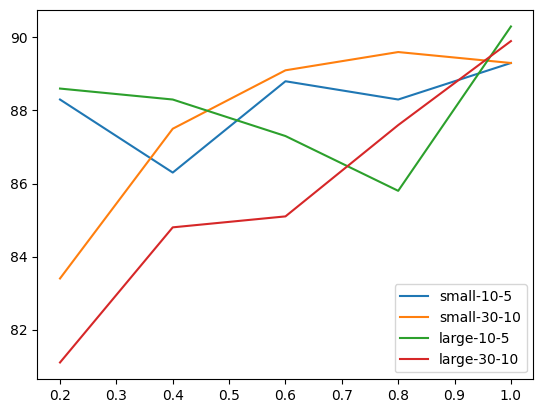

In [ ]:
plt.plot(gte_small_10_5.temperature, gte_small_10_5.overall, label="small-10-5")
plt.plot(gte_small_30_10.temperature, gte_small_30_10.overall, label="small-30-10")
plt.plot(gte_large_10_5.temperature, gte_large_10_5.overall, label="large-10-5")
plt.plot(gte_large_30_10.temperature, gte_large_30_10.overall, label="large-30-10")
plt.legend()
plt.show()